## Vision Transformer - V2

In [2]:
# ViT-v2 - Vision Transformer with regularization (PyTorch)
import os
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import cycle
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

In [3]:
%run data.ipynb

Data root: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Total Trainable Data:  112120
Training set size:  60
Validation set size:  20
Test set size:  20
Images path: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Training batches: 2
Validation batches: 1
Test batches: 1


In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
# MLP block with L2 regularization (weight_decay will be applied via optimizer)
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [6]:
# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=32, in_channels=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Use Conv2d as the patch projection
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

In [7]:
# Visualize patches from sample image
def visualize_patches(dataloader, patch_size=32):
    """Visualize image patches from a sample"""
    for images, labels in dataloader:
        image = images[0]
        break
    
    image_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    image_size = image_np.shape[0]
    num_patches = (image_size // patch_size) ** 2
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()
    
    n = int(np.sqrt(num_patches))
    plt.figure(figsize=(4, 4))
    for i in range(n):
        for j in range(n):
            ax = plt.subplot(n, n, i * n + j + 1)
            patch = image_np[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            plt.imshow(patch)
            plt.axis("off")
    plt.suptitle(f"Image divided into {num_patches} patches")
    plt.tight_layout()
    plt.show()

print("Patch visualization function ready")

Patch visualization function ready


In [8]:
# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), embed_dim, dropout)
        
    def forward(self, x):
        x_norm = self.ln1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        x = x + self.mlp(self.ln2(x))
        return x

In [9]:
# Model hyperparameters
image_size = 224
patch_size = 32
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 8
mlp_head_units = [2048, 1024]
num_classes = 15  # Will be updated from data.ipynb

print(f"ViT-v2 Configuration:")
print(f"  Image size: {image_size}x{image_size}")
print(f"  Patch size: {patch_size}x{patch_size}")
print(f"  Number of patches: {num_patches}")
print(f"  Projection dimension: {projection_dim}")
print(f"  Number of attention heads: {num_heads}")
print(f"  Transformer layers: {transformer_layers}")

ViT-v2 Configuration:
  Image size: 224x224
  Patch size: 32x32
  Number of patches: 49
  Projection dimension: 64
  Number of attention heads: 4
  Transformer layers: 8


In [10]:
# Training hyperparameters (V2 has different regularization)
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-5  # Stronger weight decay than V1
num_epochs = 10
early_stopping_patience = 3

print(f"Training Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Epochs: {num_epochs}")
print(f"  Early stopping patience: {early_stopping_patience}")

Training Configuration:
  Batch size: 32
  Learning rate: 0.0001
  Weight decay: 1e-05
  Epochs: 10
  Early stopping patience: 3


In [11]:
# Optimizer options (V2 offers multiple choices)
def get_optimizer(model, optimizer_name='sgd'):
    """Get optimizer by name"""
    optimizers = {
        "adam": optim.Adam(model.parameters(), lr=learning_rate),
        "adamw": optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
        "sgd": optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=weight_decay),
        "sgd_momentum": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
        "rmsprop": optim.RMSprop(model.parameters(), lr=learning_rate),
    }
    return optimizers.get(optimizer_name, optimizers["sgd"])

# Default optimizer choice for V2
selected_optimizer = "sgd"
print(f"Selected optimizer: {selected_optimizer}")

Selected optimizer: sgd


In [12]:
# Vision Transformer Model V2 (with stronger regularization)
class VisionTransformerV2(nn.Module):
    def __init__(self, img_size=224, patch_size=32, in_channels=3, num_classes=15,
                 embed_dim=64, depth=8, num_heads=4, mlp_ratio=4, dropout=0.1):
        super().__init__()
        
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Positional embedding (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Final layer norm
        self.ln = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Classification head (NO extra dropout - regularization via weight_decay)
        self.head = nn.Sequential(
            nn.Linear(embed_dim * self.num_patches, mlp_head_units[0]),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_head_units[0], mlp_head_units[1]),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_head_units[1], num_classes)
        )
        
        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.ln(x)
        x = x.flatten(1)
        x = self.head(x)
        
        return x

def create_vit_v2_classifier(num_classes=15):
    """Create ViT V2 model"""
    model = VisionTransformerV2(
        img_size=image_size,
        patch_size=patch_size,
        num_classes=num_classes,
        embed_dim=projection_dim,
        depth=transformer_layers,
        num_heads=num_heads,
        mlp_ratio=2,
        dropout=0.1
    )
    return model

print("VisionTransformerV2 class defined")

VisionTransformerV2 class defined


In [13]:
# Training function V2 with early stopping and LR scheduler
def train_model_v2(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                   num_epochs=10, patience=3, save_path='files/vit_v2_best.pth'):
    """Train ViT V2 model with early stopping and LR scheduling"""
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': [],
        'lr': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        all_train_targets = []
        all_train_outputs = []
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.numel()
            
            all_train_targets.append(labels.cpu().numpy())
            all_train_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate training metrics
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_correct / train_total * 100
        
        all_train_targets = np.vstack(all_train_targets)
        all_train_outputs = np.vstack(all_train_outputs)
        try:
            valid_classes = [i for i in range(all_train_targets.shape[1]) 
                           if len(np.unique(all_train_targets[:, i])) > 1]
            if len(valid_classes) > 0:
                epoch_train_auc = roc_auc_score(
                    all_train_targets[:, valid_classes],
                    all_train_outputs[:, valid_classes],
                    average='macro'
                )
            else:
                epoch_train_auc = 0.0
        except ValueError:
            epoch_train_auc = 0.0
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['train_auc'].append(epoch_train_auc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_targets = []
        all_val_outputs = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()
                
                all_val_targets.append(labels.cpu().numpy())
                all_val_outputs.append(torch.sigmoid(outputs).cpu().numpy())
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total * 100
        
        all_val_targets = np.vstack(all_val_targets)
        all_val_outputs = np.vstack(all_val_outputs)
        try:
            valid_classes = [i for i in range(all_val_targets.shape[1]) 
                           if len(np.unique(all_val_targets[:, i])) > 1]
            if len(valid_classes) > 0:
                epoch_val_auc = roc_auc_score(
                    all_val_targets[:, valid_classes],
                    all_val_outputs[:, valid_classes],
                    average='macro'
                )
            else:
                epoch_val_auc = 0.0
        except ValueError:
            epoch_val_auc = 0.0
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)
        
        # Get current LR
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f'Epoch {epoch+1}/{num_epochs} (lr={current_lr:.6f}):')
        print(f'  Train - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%, AUC: {epoch_train_auc:.4f}')
        print(f'  Val   - Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%, AUC: {epoch_val_auc:.4f}')
        
        # LR Scheduler step (ReduceLROnPlateau)
        scheduler.step(epoch_val_loss)
        
        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f'  >> Saved best model with val_loss: {best_val_loss:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\n>> Early stopping triggered at epoch {epoch+1}')
                break
    
    return history

print("Training function V2 with early stopping defined")

Training function V2 with early stopping defined


In [14]:
# Create model and train
num_classes = len(parser.labels)
print(f"Number of classes: {num_classes}")

vit_model_v2 = create_vit_v2_classifier(num_classes=num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = get_optimizer(vit_model_v2, selected_optimizer)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

# Print model summary
total_params = sum(p.numel() for p in vit_model_v2.parameters())
trainable_params = sum(p.numel() for p in vit_model_v2.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Train model
history = train_model_v2(
    vit_model_v2, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=num_epochs, patience=early_stopping_patience
)

Number of classes: 15
Total parameters: 9,005,839
Trainable parameters: 9,005,839


Epoch 1/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/10 (lr=0.010000):
  Train - Loss: 0.7020, Acc: 55.00%, AUC: 0.4758
  Val   - Loss: 0.5777, Acc: 80.33%, AUC: 0.4009
  >> Saved best model with val_loss: 0.5777


Epoch 2/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/10 (lr=0.010000):
  Train - Loss: 0.5547, Acc: 75.89%, AUC: 0.4106
  Val   - Loss: 0.4431, Acc: 91.33%, AUC: 0.4227
  >> Saved best model with val_loss: 0.4431


Epoch 3/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/10 (lr=0.010000):
  Train - Loss: 0.4338, Acc: 85.11%, AUC: 0.4781
  Val   - Loss: 0.3354, Acc: 91.67%, AUC: 0.4846
  >> Saved best model with val_loss: 0.3354


Epoch 4/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/10 (lr=0.010000):
  Train - Loss: 0.3413, Acc: 87.89%, AUC: 0.4616
  Val   - Loss: 0.2710, Acc: 91.00%, AUC: 0.5380
  >> Saved best model with val_loss: 0.2710


Epoch 5/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/10 (lr=0.010000):
  Train - Loss: 0.2896, Acc: 89.44%, AUC: 0.5266
  Val   - Loss: 0.2428, Acc: 91.67%, AUC: 0.5648
  >> Saved best model with val_loss: 0.2428


Epoch 6/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/10 (lr=0.010000):
  Train - Loss: 0.2689, Acc: 89.78%, AUC: 0.6471
  Val   - Loss: 0.2349, Acc: 92.00%, AUC: 0.5841
  >> Saved best model with val_loss: 0.2349


Epoch 7/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/10 (lr=0.010000):
  Train - Loss: 0.2766, Acc: 89.11%, AUC: 0.5144
  Val   - Loss: 0.2358, Acc: 91.33%, AUC: 0.5890


Epoch 8/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/10 (lr=0.010000):
  Train - Loss: 0.2723, Acc: 89.67%, AUC: 0.5923
  Val   - Loss: 0.2384, Acc: 91.67%, AUC: 0.5933


Epoch 9/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/10 (lr=0.010000):
  Train - Loss: 0.2657, Acc: 89.78%, AUC: 0.5630
  Val   - Loss: 0.2413, Acc: 91.67%, AUC: 0.5947

>> Early stopping triggered at epoch 9


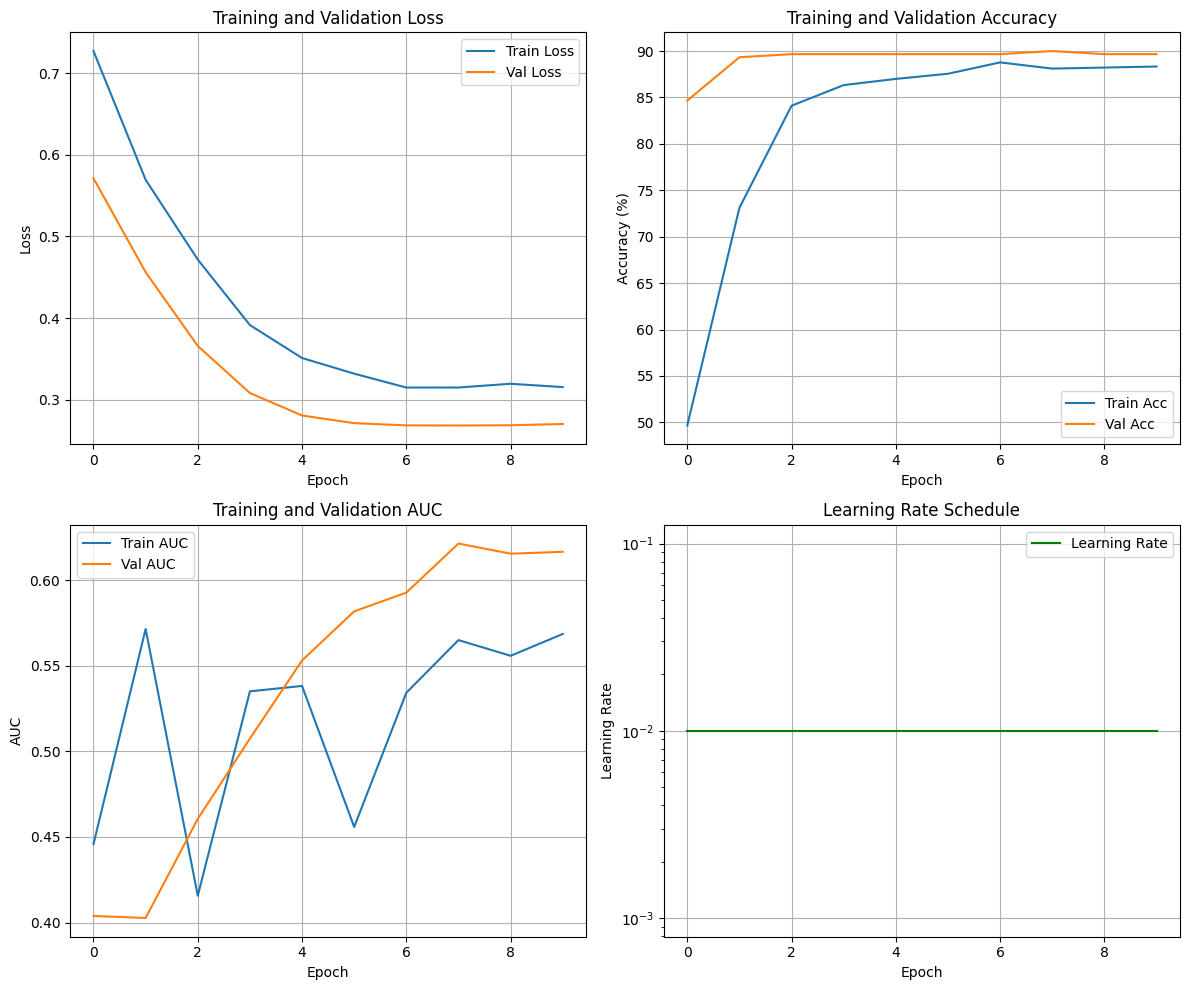

In [15]:
# Plot training history V2 (includes LR)
def plot_training_history_v2(history):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc')
    axes[0, 1].plot(history['val_acc'], label='Val Acc')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # AUC
    axes[1, 0].plot(history['train_auc'], label='Train AUC')
    axes[1, 0].plot(history['val_auc'], label='Val AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_title('Training and Validation AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', color='green')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('files/vit_v2_training_history.png', dpi=150)
    plt.show()

# Plot history
plot_training_history_v2(history)

In [16]:
# Evaluate on test set and plot ROC curves
def evaluate_and_plot_roc(model, test_loader, num_classes, class_labels):
    """Evaluate model on test set and plot ROC curves"""
    model.eval()
    all_targets = []
    all_outputs = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            test_correct += (preds == labels).sum().item()
            test_total += labels.numel()
            
            all_targets.append(labels.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total * 100
    
    all_targets = np.vstack(all_targets)
    all_outputs = np.vstack(all_outputs)
    
    try:
        valid_classes = [i for i in range(all_targets.shape[1]) 
                       if len(np.unique(all_targets[:, i])) > 1]
        if len(valid_classes) > 0:
            test_auc = roc_auc_score(
                all_targets[:, valid_classes],
                all_outputs[:, valid_classes],
                average='macro'
            )
        else:
            test_auc = 0.0
    except ValueError:
        test_auc = 0.0
    
    print(f"\nTest Results (ViT-V2):")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.2f}%")
    print(f"  AUC: {test_auc:.4f}")
    
    # Plot ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        if len(np.unique(all_targets[:, i])) > 1:
            fpr[i], tpr[i], _ = roc_curve(all_targets[:, i], all_outputs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 
                    'gray', 'olive', 'cyan', 'magenta', 'yellow', 'lime', 'navy', 'coral'])
    
    for i, color in zip(range(num_classes), colors):
        if i in roc_auc:
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - ViT-V2 Multi-Label Classification')
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True)
    plt.savefig('files/vit_v2_roc_curves.png', dpi=150)
    plt.show()
    
    return test_loss, test_acc, test_auc

print("Evaluation function defined")

Evaluation function defined


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


Test Results (ViT-V2):
  Loss: 0.2749
  Accuracy: 89.67%
  AUC: 0.6303


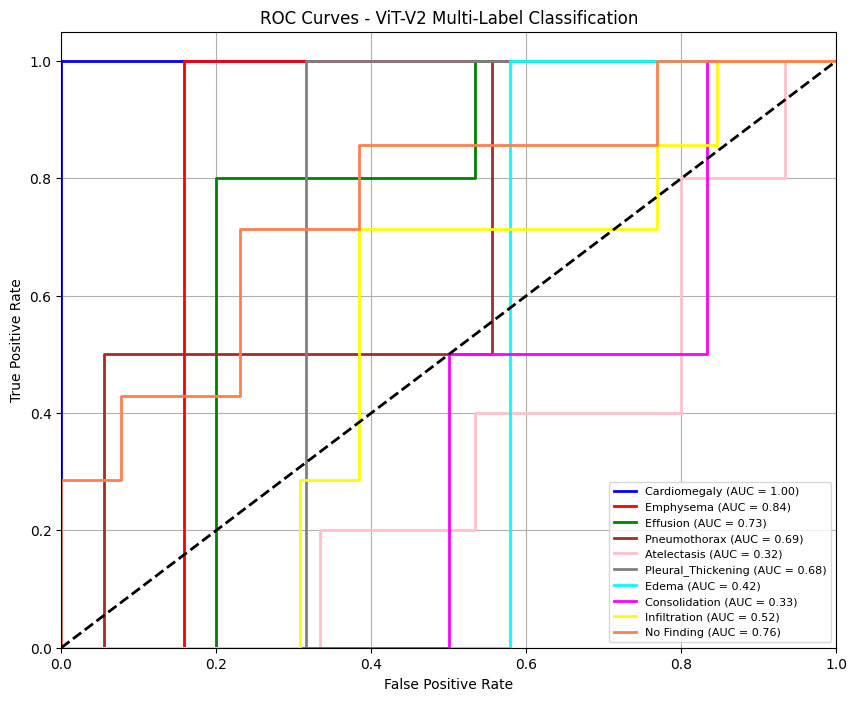

NameError: name 'evaluate_and_plot_roc' is not defined

In [ ]:
# Evaluate on test set
test_loss, test_acc, test_auc = evaluate_and_plot_roc(
    vit_model_v2, test_loader, num_classes, parser.labels
)